# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = "drive/MyDrive/645-project-data/"

Mounted at /content/drive/


In [ ]:
#Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#Check Ram
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Mar 29 22:18:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display, Image
import os
import pathlib
import glob
import shutil
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot


# Loading The Data

In [ ]:
# !mkdir train_local
# !unzip train.zip -d train_local



---



---

:

In [ ]:
labels = pd.read_csv(path + "labels.csv")
labels["id"] = [fname + ".jpg" for fname in labels["id"]]
print(f"There are a total of {labels.describe().iloc[1,:][0]} labeled images")
print(f"There are {labels.describe().iloc[1,:][1]} different dog breeds in this dataset")

There are a total of 10222 labeled images
There are 120 different dog breeds in this dataset


In [ ]:
!mkdir train_local
for index, row in labels.iterrows():
    filename = row["id"]
    breed = row["breed"]
    shutil.copy(path + "train/" + filename, "/content/train_local/" + filename)

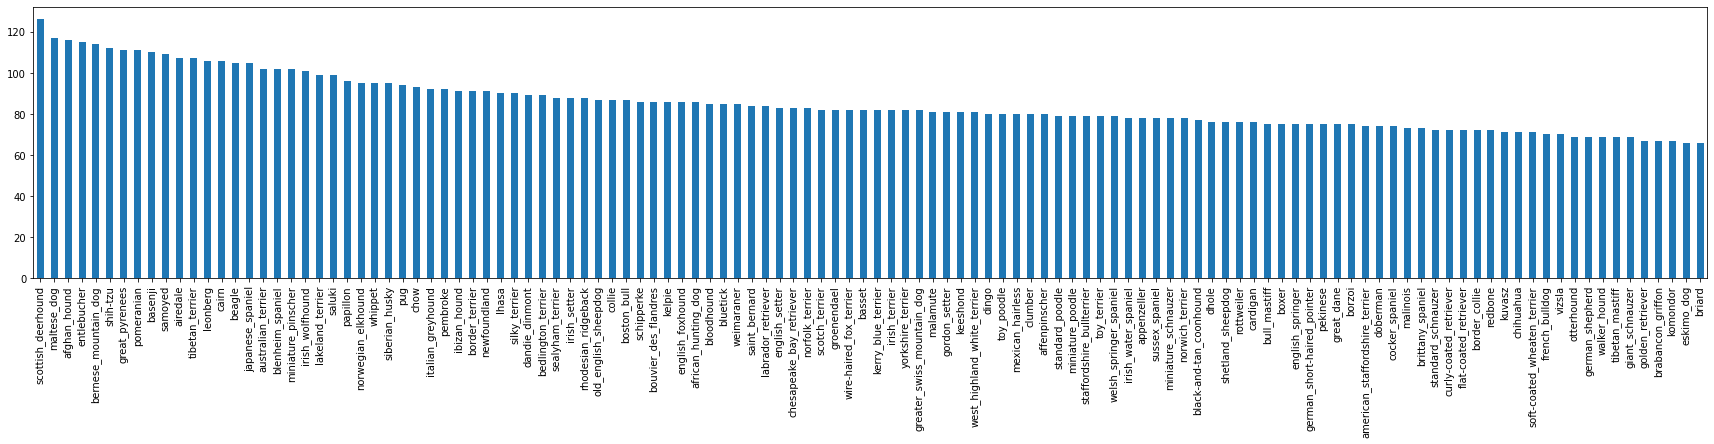

In [ ]:
labels["breed"].value_counts().plot.bar(figsize=(30, 5))
plt.show()

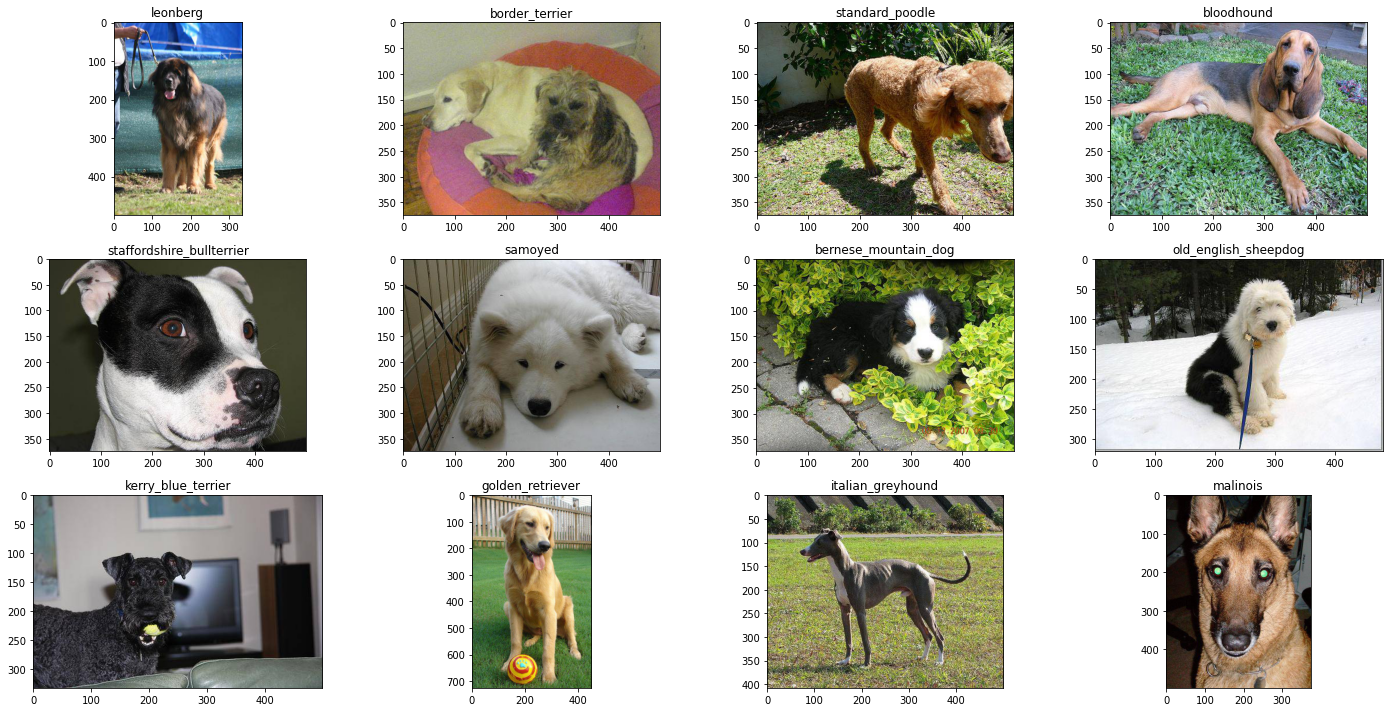

In [ ]:
sample_imgs = []
for index, row in labels.sample(12).iterrows():
    sample_imgs.append((row["id"], row["breed"]))

fig = plt.figure(figsize=(20, 10))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = mpimg.imread(path + "train/" + sample_imgs[i-1][0])
    fig.add_subplot(rows, columns, i).title.set_text(sample_imgs[i-1][1])
    plt.imshow(img)
plt.tight_layout()
plt.show()
        

# Data Augmentation & Preprocessing

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = 224

datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input, validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
                        dataframe = labels,
                        directory = "train_local",
                        x_col="id",
                        y_col="breed",
                        subset="training",
                        batch_size=BATCH_SIZE,
                        seed=42,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(IMG_SIZE, IMG_SIZE))

validation_generator = datagen.flow_from_dataframe(
                        dataframe = labels,
                        directory = "train_local",
                        x_col="id",
                        y_col="breed",
                        subset="validation",
                        batch_size=BATCH_SIZE,
                        seed=42,
                        shuffle=True, 
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(IMG_SIZE, IMG_SIZE))

Found 7667 validated image filenames belonging to 120 classes.
Found 2555 validated image filenames belonging to 120 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

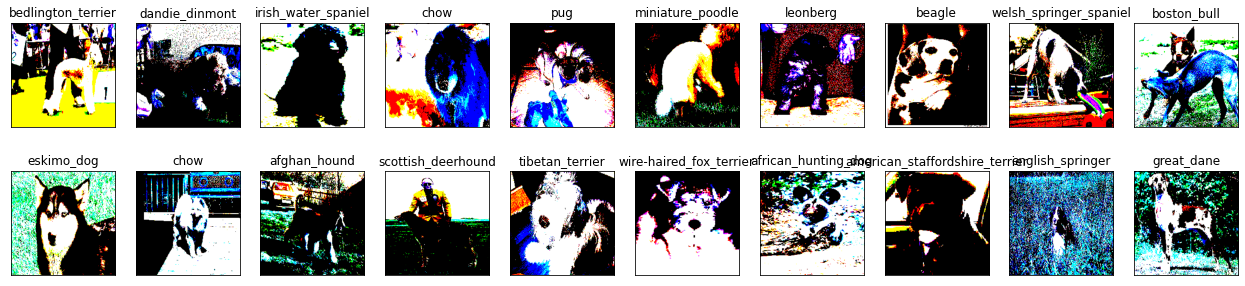

In [ ]:
class_names = [name for name in train_generator.class_indices.keys()]
images, labels = next(iter(train_generator))

fig = plt.figure(figsize=(22, 5))

for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(images[i])
  ax.set_title(class_names[int(labels[i])])

# Modelling

In [ ]:
resnet_model = tf.keras.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

        
resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 120)               12042360  
                                                                 
Total params: 35,630,072
Trainable params: 12,042,360
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model_name_it = "dog_breed_classifier_resnet50.h5"
model_name_ft = "dog_breed_classifier_resnet50.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 15)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3,rho=0.9)

resnet_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_it = resnet_model.fit(train_generator, epochs=20, verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (validation_generator))

Epoch 1/20
120/120 [==============================] - 62s 414ms/step - loss: 20.9948 - accuracy: 0.4325 - val_loss: 16.9874 - val_accuracy: 0.5413 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 46s 387ms/step - loss: 2.6657 - accuracy: 0.8984 - val_loss: 17.9940 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 46s 384ms/step - loss: 1.0800 - accuracy: 0.9545 - val_loss: 19.3555 - val_accuracy: 0.5937 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 46s 382ms/step - loss: 0.8722 - accuracy: 0.9657 - val_loss: 18.9919 - val_accuracy: 0.6059 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 46s 385ms/step - loss: 0.7087 - accuracy: 0.9716 - val_loss: 22.9365 - val_accuracy: 0.5738 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 46s 387ms/step - loss: 0.6344 - accuracy: 0.9759 - val_loss: 22.5148 - val_accuracy: 0.5730 - lr: 0.0010
Epoch 7/20
120/120 [=========================